<a href="https://colab.research.google.com/github/erYash15/Real-or-Not-NLP-with-Disaster-Tweets/blob/master/Real_or_Not_NLP_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DISASTER TWEETS

## **Problem Understanding**

Goal: Build a classifier that predicts whether a tweet is about a disaster (e.g., earthquake, flood, fire) or not.

Output: Binary classification (disaster vs. non-disaster tweet).

## Libraries

In [315]:
! pip install demoji

In [316]:
! pip install wordcloud

In [317]:
# Data Manipulation libraries
import numpy as np 
import pandas as pd 

import os

# NLP libraries
import string 
import nltk 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re # Regex library
import demoji
from wordcloud import WordCloud

# ploting libraries
import matplotlib.pyplot as plt

# ML/AI libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout 
from tensorflow.python.keras.initializers import RandomNormal

## Loading Data

In [318]:
#@title
data = pd.read_csv("C:/Data Science/project_7/data/tweets.csv")

# Basic Info
print("Total DataSet: ", len(data))
print("Columns: ", list(data.columns))

X = data[["id", "keyword", "location", "text"]] # Features
y = data[["id","target"]] #Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Data", len(y_train))
print("Testing Data", len(y_test))

data.head(3)

Total DataSet:  11370
Columns:  ['id', 'keyword', 'location', 'text', 'target']
Training Data 9096
Testing Data 2274


,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1


## Exploratory Data Analysis

### Analyzing Lables

In [319]:
Real_len = data[data['target'] == 1].shape[0]
Not_len = data[data['target'] == 0].shape[0]

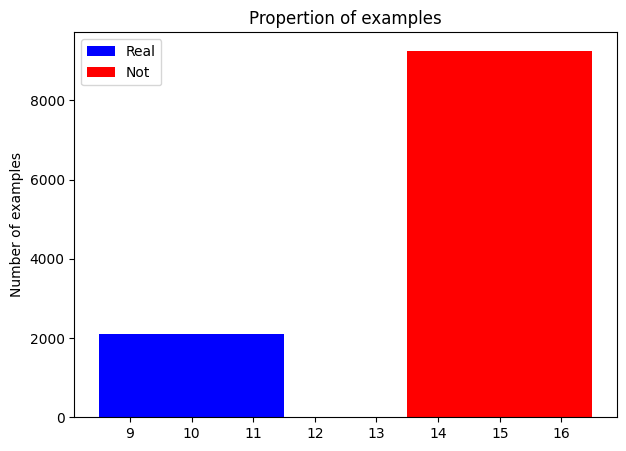

In [320]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

### Analyzing Features

#### Sentence length analysis

In [321]:
def length(string):    
    return len(string)
data['length'] = data['text'].apply(length)

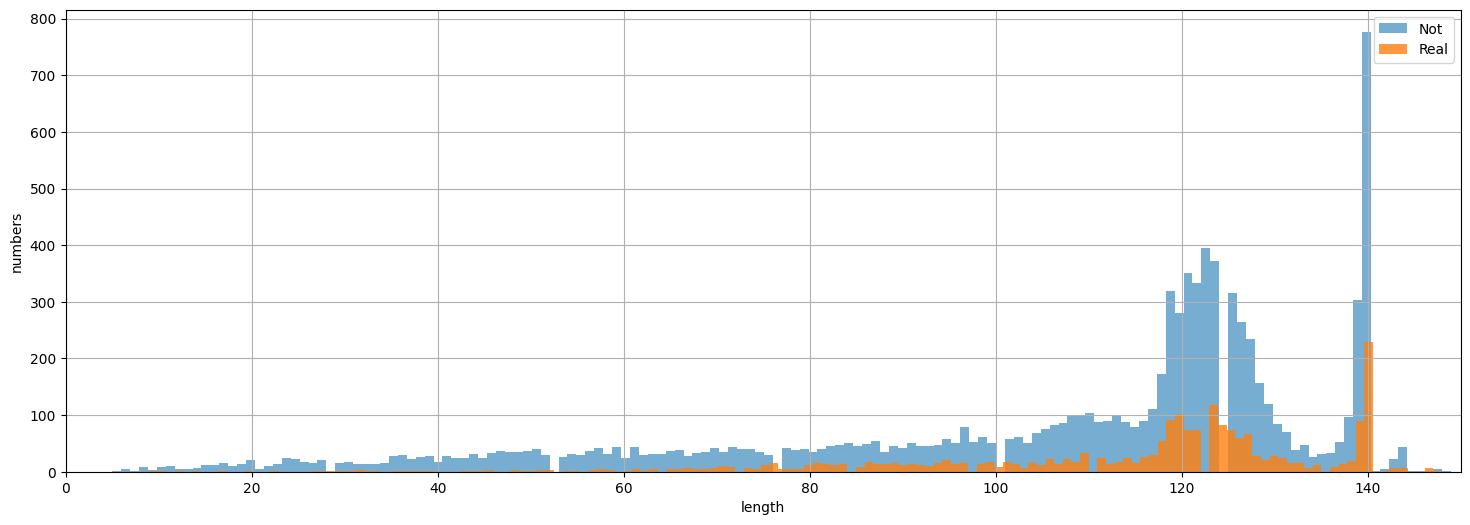

In [322]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(data[data['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(data[data['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

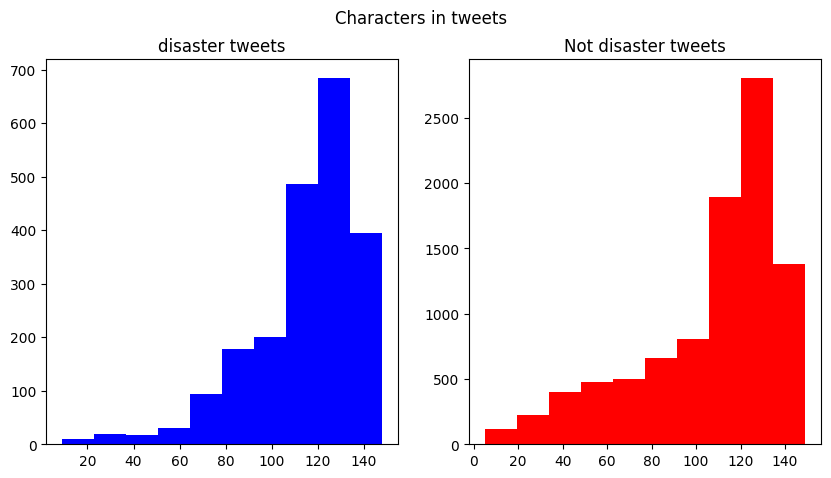

In [323]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data[data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=data[data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

## Data Cleaning 

Data cleaning is the process of preparing data for analysis by removing or modifying data that is incorrect, incomplete, irrelevant, duplicated, or improperly formatted.<br><br>
Step 1. Remove Url<br>
Step 2. Handle Tags<br>
Step 3. Handle emoji's<br>
Step 4. Remove HTML Tags<br>
Step 5. Remove stopwords<br>
Step 6. Removing Useless Characters

### Step 1. Remove Url

In [324]:

def Remove_Url(string):
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%|\-)*\b', '', string)

In [325]:
print("Example of text with URL: \n", X_train['text'][3912], end = "\n\n")
X_train['text'] = X_train['text'].apply(Remove_Url)
print("Example of text without URL: \n", X_train['text'][3912])

Example of text with URL: 
 why the hell would want to join the Kenyan Cabinet? why would… https://t.co/l91GiZ6Wjr

Example of text without URL: 
 why the hell would want to join the Kenyan Cabinet? why would… 


### Step 2. Handle Tags

In [326]:
def Handle_Tags(string):
    pattern = re.compile(r'[@|#][^\s]+')
    matches = pattern.findall(string)
    tags = [match[1:] for match in matches]
    # Removing tags from main string
    string = re.sub(pattern, '', string)
    # More weightage to tag by adding them 3 times
    return string + ' ' + ' '.join(tags) + ' '+ ' '.join(tags) + ' ' + ' '.join(tags)

In [327]:
print("Example of text without Handling Tags: \n", X_train['text'][3914],end = "\n\n")
X_train['text'] = X_train['text'].apply(Handle_Tags)
print("Example of text with Handling Tags: \n", X_train['text'][3914])

Example of text without Handling Tags: 
 #WednesdayWisdom Those who say that they have appeared to destroy all the locos He is worshiping them as full divine Mu…

Example of text with Handling Tags: 
  Those who say that they have appeared to destroy all the locos He is worshiping them as full divine Mu… WednesdayWisdom WednesdayWisdom WednesdayWisdom


### Step 3. Handle emoji's

In [328]:

demoji.download_codes()

C:\Users\PC\AppData\Local\Temp\ipykernel_12176\3261177172.py:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [329]:
def Handle_emoji(string):
    return demoji.replace_with_desc(string)

In [330]:
print("Example of text without Handled Emojis: \n", X_train['text'][17],end = "\n\n")
X_train['text'] = X_train['text'].apply(Handle_emoji)
print("Example of text with Handled Emoji: \n", X_train['text'][17])


Example of text without Handled Emojis: 
 Rengoku sets my heart ablaze😔❤️🔥 P.s. I missed this style of coloring I do so here it is c:   鬼滅の刃 鬼滅の刃 鬼滅の刃

Example of text with Handled Emoji: 
 Rengoku sets my heart ablaze:pensive face::red heart::fire: P.s. I missed this style of coloring I do so here it is c:   鬼滅の刃 鬼滅の刃 鬼滅の刃


### Step 4. Remove HTML Tags

In [331]:
def Remove_html(string):
    return re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', str(string))

In [332]:
X_train['text'] = X_train['text'].apply(Remove_html)

### Step 5. Remove Stopwords and Stemming

In [333]:
nltk.download('punkt')
nltk.download('stopwords')
stemmer  = SnowballStemmer('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [334]:
stopword = stopwords.words('english')
def Remove_StopAndStem(string):
    string_list = string.split()
    return ' '.join([stemmer.stem(i) for i in string_list if i not in stopword])

In [335]:
print("Example of text before Removing Stopwords: \n", X_train['text'][17],end = "\n\n")
X_train['text'] = X_train['text'].apply(Remove_StopAndStem)
print("Example of text after Removing Stopwords and Stemming: \n", X_train['text'][17])

Example of text before Removing Stopwords: 
 Rengoku sets my heart ablaze:pensive face::red heart::fire: P.s. I missed this style of coloring I do so here it is c:   鬼滅の刃 鬼滅の刃 鬼滅の刃

Example of text after Removing Stopwords and Stemming: 
 rengoku set heart ablaze:pens face::r heart::fire: p.s. i miss style color i c: 鬼滅の刃 鬼滅の刃 鬼滅の刃


### Step 6. Removing Useless Characters

In [336]:
def Remove_UC(string):
    thestring = re.sub(r'[^a-zA-Z\s]','', string)
    # remove word of length less than 2
    thestring = re.sub(r'\b\w{1,2}\b', '', thestring)
    #https://www.geeksforgeeks.org/python-remove-unwanted-spaces-from-string/
    return re.sub(' +', ' ', thestring) 

In [337]:
print("Example of text before Removing Useless Character: \n", X_train['text'][17],end = "\n\n")
X_train['text'] = X_train['text'].apply(Remove_UC)
print("Example of text after Removing Useless Character: \n", X_train['text'][17])

Example of text before Removing Useless Character: 
 rengoku set heart ablaze:pens face::r heart::fire: p.s. i miss style color i c: 鬼滅の刃 鬼滅の刃 鬼滅の刃

Example of text after Removing Useless Character: 
 rengoku set heart ablazepens facer heartfire miss style color 


In [338]:
def merging_details(data):
        #df = pd.DataFrame(columns=['id', 'Cleaned_data'])
        df_list = []
        
        #https://www.geeksforgeeks.org/how-to-iterate-over-rows-in-pandas-dataframe/
        for row in data.itertuples():
            df_dict = {}
            # Processing Keyword and location
            keyword = re.sub(r'[^a-zA-Z\s]','', str(row[2]))
            location = re.sub(r'[^a-zA-Z\s]','', str(row[3]))
            keyword = re.sub(r'\b\w{1,2}\b', '', keyword)
            location = re.sub(r'\b\w{1,2}\b', '', location)
            # Already processed data
            text = str(row[4])

            if keyword == 'nan':
                if location == 'nan':    
                    prs_data = text
                else:
                    prs_data = location + ' ' + text
            else:
                if location == 'nan':    
                    prs_data = keyword + ' ' + text
                else:
                    prs_data = keyword + ' ' + location + ' ' + text                
            
            prs_data = re.sub(' +', ' ', prs_data) 
            
            df_dict['Cleaned_data'] = prs_data
            
            df_list.append(df_dict)
                 
        return pd.DataFrame(df_list)

In [339]:
X_train = merging_details(X_train)

In [340]:
X_train

,Cleaned_data
0,destroy hell would want join kenyan cabinet would
1,flooding citizen unit wreak havoc democracy de...
2,wreckage through happi sorrow guess again live...
3,derailed Pittsburgh rememb cheer derail campai...
4,wrecked Oklahoma City first listen also whip d...
...,...
9091,wreck after caus wreck theyr like
9092,explosion Lagos Nigeria let get starboy subscr...
9093,fatalities been long day storm survey one team...
9094,blaze Kampala Uganda work next one lead govern...


###  WORDCLOUD 

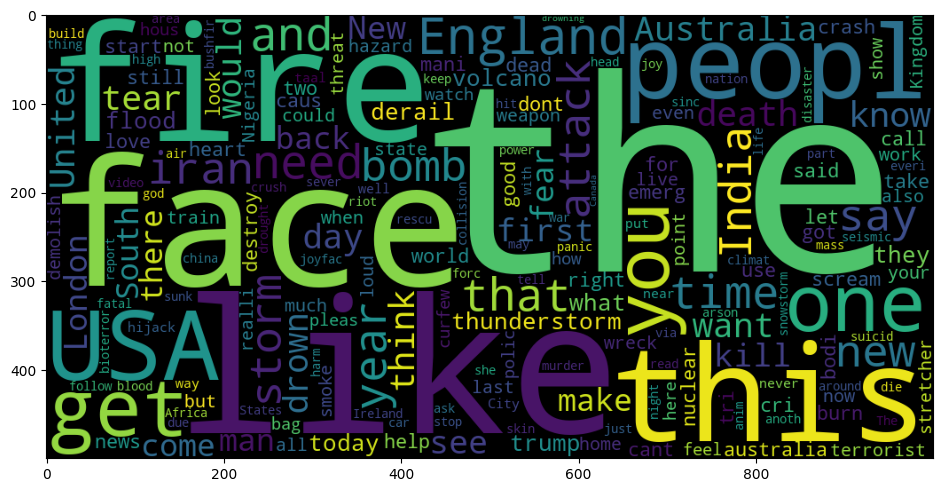

CPU times: total: 1.39 s
Wall time: 1.83 s


In [341]:
%%time
dict_of_words = {}
for row in  X_train.itertuples():
    for i in row[1].split():
        try:
            dict_of_words[i] += 1
        except:
            dict_of_words[i] = 1

#Initializing  WordCloud
wordcloud = WordCloud(background_color = 'black', width=1000, height=500).generate_from_frequencies(dict_of_words)
fig = plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.tight_layout(pad=1)
plt.show()

## Final Pre-Processing Data

In [342]:
# Step 1. Remove Url
X_test['text'] = X_test['text'].apply(Remove_Url)
# Step 2. Handle Tags
X_test['text'] = X_test['text'].apply(Handle_Tags)
# Step 3. Handle emoji's
X_test['text'] = X_test['text'].apply(Handle_emoji)
# Step 4. Remove HTML Tags
X_test['text'] = X_test['text'].apply(Remove_html)
# Step 5. Remove Stopwords and Stemming
X_test['text'] = X_test['text'].apply(Remove_StopAndStem)
# Step 6. Removing Useless Characters
X_test['text'] = X_test['text'].apply(Remove_UC)
# Step7. Merging Other Details
X_test = merging_details(X_test)

In [343]:
X_test

,Cleaned_data
0,demolished Observation drone how mani illeg bu...
1,fatality who fatal tho
2,sunk London chines state media confirm iranian...
3,windstorm London with luck miss windstorm eith...
4,buildingsonfire inferno black friday deaths bu...
...,...
2269,eyewitness United States plp leader call hypoc...
2270,thunderstorm Pluto cant sleep open window take...
2271,attacked Lagos Nigeria son teenag girl arrest ...
2272,loudbang Michigan USA brother got bathroom hea...


In [344]:
y_train = y_train['target']
y_test = y_test['target']

In [345]:
%%time

vectorizer = TfidfVectorizer(min_df = 0.0005, 
                             max_features = 100000, 
                             tokenizer = tokenizer_function,
                             ngram_range = (1,4))


X_train = vectorizer.fit_transform(X_train['Cleaned_data'])
X_test = vectorizer.transform(X_test['Cleaned_data'])


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: total: 1.58 s
Wall time: 1.87 s


In [ ]:
#https://stackoverflow.com/questions/16505670/generating-a-dense-matrix-from-a-sparse-matrix-in-numpy-python
print("Training Points: ", len(X_train.toarray()),"| Training Features:" , len(X_train.toarray()[0]))
print("Testing Points: ", len(X_test.toarray()),"| Testing Features:" , len(X_test.toarray()[0]))
print()
print("Training Points: ", len(y_train))
print("Testing Points: ", len(y_test))

Training Points:  9096 | Training Features: 4678
Testing Points:  2274 | Testing Features: 4678

Training Points:  9096
Testing Points:  2274


## Machine Learning

### Logistic Regression 

In [ ]:
%%time

Model = LogisticRegression(C=1,penalty='l2')

Model.fit(X_train, y_train)

y_pred = Model.predict(X_test)
print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.882145998240985
Macro precision_recall_fscore_support
(0.871807723646968, 0.6865258011424146, 0.7328313480129552, None)
Micro precision_recall_fscore_support
(0.882145998240985, 0.882145998240985, 0.882145998240985, None)
Weighted precision_recall_fscore_support
(0.8797959003666412, 0.882145998240985, 0.86299859015292, None)
CPU times: total: 93.8 ms
Wall time: 113 ms


### Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
%%time
Model = GaussianNB()
Model.fit(X_train.toarray(), y_train)
y_pred = Model.predict(X_test.toarray())

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.6543535620052771
Macro precision_recall_fscore_support
(0.6183811954769804, 0.7030528931487399, 0.5947656286133786, None)
Micro precision_recall_fscore_support
(0.6543535620052771, 0.6543535620052771, 0.6543535620052771, None)
Weighted precision_recall_fscore_support
(0.8218584748469638, 0.6543535620052771, 0.696037781465206, None)
CPU times: total: 3.25 s
Wall time: 5.43 s


#### Bernoulli Naive Bayes

In [ ]:
%%time
Model = BernoulliNB()
Model.fit(X_train.toarray(), y_train)
y_pred = Model.predict(X_test.toarray())

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8948988566402815
Macro precision_recall_fscore_support
(0.8415110917021487, 0.7649901571626812, 0.7951047820043453, None)
Micro precision_recall_fscore_support
(0.8948988566402815, 0.8948988566402815, 0.8948988566402815, None)
Weighted precision_recall_fscore_support
(0.8882727156018607, 0.8948988566402815, 0.8882962241029322, None)
CPU times: total: 1.11 s
Wall time: 882 ms


#### Complement Naive Bayes

In [ ]:
%%time
Model = ComplementNB()
Model.fit(X_train.toarray(), y_train)
y_pred = Model.predict(X_test.toarray())

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8570800351802991
Macro precision_recall_fscore_support
(0.7536186200895507, 0.795898279923839, 0.7712363575244062, None)
Micro precision_recall_fscore_support
(0.8570800351802991, 0.8570800351802991, 0.8570800351802991, None)
Weighted precision_recall_fscore_support
(0.8712028357064902, 0.8570800351802991, 0.8625646635445304, None)
CPU times: total: 594 ms
Wall time: 432 ms


####  Multinomial Naive Bayes

In [ ]:
%%time
Model = MultinomialNB()
Model.fit(X_train.toarray(), y_train)
y_pred = Model.predict(X_test.toarray())

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8812664907651715
Macro precision_recall_fscore_support
(0.878383190883191, 0.6800150062929615, 0.7267527557036657, None)
Micro precision_recall_fscore_support
(0.8812664907651715, 0.8812664907651715, 0.8812664907651715, None)
Weighted precision_recall_fscore_support
(0.880588067263529, 0.8812664907651715, 0.8606646594236373, None)
CPU times: total: 609 ms
Wall time: 437 ms


### Support Vector Machines (SVM)

#### RBF Kernel SVM

In [ ]:
%%time
Model = svm.SVC(kernel='rbf') 
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8913808267370272
Macro precision_recall_fscore_support
(0.8787831991418029, 0.7160301094007164, 0.7632195643861869, None)
Micro precision_recall_fscore_support
(0.8913808267370272, 0.8913808267370272, 0.8913808267370272, None)
Weighted precision_recall_fscore_support
(0.8887991240860746, 0.8913808267370272, 0.8767491464566863, None)
CPU times: total: 8.28 s
Wall time: 9.66 s


#### Linear Kernel SVM 

In [ ]:
%%time
Model = svm.SVC(kernel='linear') 
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8927000879507476
Macro precision_recall_fscore_support
(0.8499157899593945, 0.7447276277148481, 0.7821254058231201, None)
Micro precision_recall_fscore_support
(0.8927000879507476, 0.8927000879507476, 0.8927000879507476, None)
Weighted precision_recall_fscore_support
(0.8859830991876001, 0.8927000879507476, 0.8832807631769127, None)
CPU times: total: 4.98 s
Wall time: 5.15 s


### Random Forest 

In [ ]:
%%time
Model = RandomForestClassifier(random_state=0)
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.886103781882146
Macro precision_recall_fscore_support
(0.8497576053359361, 0.7168207635460031, 0.758488551327426, None)
Micro precision_recall_fscore_support
(0.886103781882146, 0.886103781882146, 0.886103781882146, None)
Weighted precision_recall_fscore_support
(0.8792888737797316, 0.886103781882146, 0.8729022063075199, None)
CPU times: total: 8.94 s
Wall time: 9.1 s


## Deep Learning 

In [ ]:
# some model parameters
output_dim = 1
input_dim = X_train.shape[1]

batch_size = 200 
nb_epoch = 100

### Single Layer Perceptron

In [ ]:
%%time
# start building a model
model = Sequential()

model.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))
model.summary()
y_pred = model.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1859 - loss: 0.6825 - val_accuracy: 0.1741 - val_loss: 0.6510
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1861 - loss: 0.6443 - val_accuracy: 0.1741 - val_loss: 0.6173
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1849 - loss: 0.6135 - val_accuracy: 0.1741 - val_loss: 0.5905
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1886 - loss: 0.5904 - val_accuracy: 0.1741 - val_loss: 0.5688
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1874 - loss: 0.5704 - val_accuracy: 0.1741 - val_loss: 0.5513
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1933 - loss: 0.5585 - val_accuracy: 0.1741 - val_loss: 0.5370
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1872 - loss: 0.5426 - val_accuracy: 0.1741 - val_loss: 0.5253
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1884 - loss: 0.5328 - val_accuracy: 0.1741 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │         4,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,681 (18.29 KB)

 Trainable params: 4,679 (18.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

66/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Acuracy 0.1741424802110818
Macro precision_recall_fscore_support
(0.0870712401055409, 0.5, 0.14831460674157304, None)
Micro precision_recall_fscore_support
(0.1741424802110818, 0.1741424802110818, 0.1741424802110818, None)
Weighted precision_recall_fscore_support
(0.030325603414067013, 0.1741424802110818, 0.05165574693901752, None)
CPU times: total: 52.5 s
Wall time: 38.5 s


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Multilayer perceptron

In [ ]:
input_dim = X_train.shape[1]
hidden_layer_1 = 1560 # input_dim // 3
hidden_layer_2 = 519 # hidden_layer_1 // 3
hidden_layer_3 = 173 # hidden_layer_2 // 3
output_dim = 1 

batch_size = 200 
nb_epoch = 100

#### Model 1 : SIGMOID + ADAM

In [ ]:
%%time

model_sigmoid = Sequential()
model_sigmoid.add(Dense(hidden_layer_1, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.0179, seed=None)))
model_sigmoid.add(Dense(hidden_layer_2, activation='sigmoid',kernel_initializer=RandomNormal(mean=0.0, stddev=0.0310, seed=None)))
model_sigmoid.add(Dense(hidden_layer_3, activation='sigmoid',kernel_initializer=RandomNormal(mean=0.0, stddev=0.0537, seed=None)))
model_sigmoid.add(Dense(output_dim, activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.107, seed=None)))

model_sigmoid.summary()

model_sigmoid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_sigmoid.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))

y_pred = model_sigmoid.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1560)           │     7,299,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 519)            │       810,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 173)            │        89,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,199,533 (31.28 MB)

 Trainable params: 8,199,533 (31.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.1898 - loss: 0.5242 - val_accuracy: 0.1741 - val_loss: 0.4849
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.1849 - loss: 0.4882 - val_accuracy: 0.1741 - val_loss: 0.4620
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.1865 - loss: 0.4808 - val_accuracy: 0.1741 - val_loss: 0.4729
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.1917 - loss: 0.4891 - val_accuracy: 0.1741 - val_loss: 0.4584
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.1856 - loss: 0.4696 - val_accuracy: 0.1741 - val_loss: 0.4023
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.1856 - loss: 0.3693 - val_accuracy: 0.1741 - val_loss: 0.2857
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.1897 - loss: 0.2267 - val_accuracy: 0.1741 - val_loss: 0.2950
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.1868 - loss: 0.1873 - val_accuracy: 0.174

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Acuracy 0.1741424802110818
Macro precision_recall_fscore_support
(0.0870712401055409, 0.5, 0.14831460674157304, None)
Micro precision_recall_fscore_support
(0.1741424802110818, 0.1741424802110818, 0.1741424802110818, None)
Weighted precision_recall_fscore_support
(0.030325603414067013, 0.1741424802110818, 0.05165574693901752, None)
CPU times: total: 35min 22s
Wall time: 13min 39s


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Model 2 : SIGMOID + SGD

In [ ]:
%%time
model_sigmoid = Sequential()
model_sigmoid.add(Dense(hidden_layer_1, activation='sigmoid', input_shape=(input_dim,)))
model_sigmoid.add(Dense(hidden_layer_2, activation='sigmoid'))
model_sigmoid.add(Dense(hidden_layer_3, activation='sigmoid'))
model_sigmoid.add(Dense(output_dim, activation='softmax'))

model_sigmoid.summary()

model_sigmoid.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_sigmoid.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))

y_pred = model_sigmoid.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1560)           │     7,299,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 519)            │       810,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 173)            │        89,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,199,533 (31.28 MB)

 Trainable params: 8,199,533 (31.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.1835 - loss: 0.4899 - val_accuracy: 0.1741 - val_loss: 0.4629
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.1866 - loss: 0.4813 - val_accuracy: 0.1741 - val_loss: 0.4629
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.1830 - loss: 0.4760 - val_accuracy: 0.1741 - val_loss: 0.4641
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1872 - loss: 0.4824 - val_accuracy: 0.1741 - val_loss: 0.4635
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.1892 - loss: 0.4851 - val_accuracy: 0.1741 - val_loss: 0.4631
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1956 - loss: 0.4945 - val_accuracy: 0.1741 - val_loss: 0.4628
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.1853 - loss: 0.4795 - val_accuracy: 0.1741 - val_loss: 0.4632
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.1905 - loss: 0.4871 - val_accuracy: 0.1741 - val_

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Acuracy 0.1741424802110818
Macro precision_recall_fscore_support
(0.0870712401055409, 0.5, 0.14831460674157304, None)
Micro precision_recall_fscore_support
(0.1741424802110818, 0.1741424802110818, 0.1741424802110818, None)
Weighted precision_recall_fscore_support
(0.030325603414067013, 0.1741424802110818, 0.05165574693901752, None)
CPU times: total: 16min 21s
Wall time: 7min 11s


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Model 3 : RELU + ADAM

In [ ]:
%%time


model_relu = Sequential()
model_relu.add(Dense(hidden_layer_1, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dense(hidden_layer_2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dense(hidden_layer_3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0620, seed=None)))
model_relu.add(Dense(1, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.107, seed=None)))

model_relu.summary()

model_relu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))

y_pred = model_relu.predict(X_test)

for i in range(len(y_pred)):
  if y_pred[i][0] >= 0.5:
    y_pred[i][0] = 1
  else:
    y_pred[i][0] = 0

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 1560)           │     7,299,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 519)            │       810,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 173)            │        89,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,199,533 (31.28 MB)

 Trainable params: 8,199,533 (31.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.8222 - loss: 0.4912 - val_accuracy: 0.8945 - val_loss: 0.3553
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.9461 - loss: 0.1752 - val_accuracy: 0.8967 - val_loss: 0.3926
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.9853 - loss: 0.0885 - val_accuracy: 0.8874 - val_loss: 1.0262
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.9916 - loss: 0.0819 - val_accuracy: 0.8905 - val_loss: 0.9743
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.9952 - loss: 0.0642 - val_accuracy: 0.8887 - val_loss: 1.0560
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.9956 - loss: 0.0594 - val_accuracy: 0.8914 - val_loss: 1.1235
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.9936 - loss: 0.0716 - val_accuracy: 0.8945 - val_loss: 1.1271
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9945 - loss: 0.0699 - val_acc

#### Model 4 : RELU + SGD

In [ ]:
%%time


model_relu = Sequential()
model_relu.add(Dense(hidden_layer_1, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dense(hidden_layer_2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dense(hidden_layer_3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0620, seed=None)))
model_relu.add(Dense(1, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=1, seed=None)))

model_relu.summary()

model_relu.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))




y_pred_prob = model_relu.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support:")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support:")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support:")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 1560)           │     7,299,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 519)            │       810,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 173)            │        89,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,199,533 (31.28 MB)

 Trainable params: 8,199,533 (31.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.2464 - loss: 11.8379 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.1814 - loss: 13.0509 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.1873 - loss: 12.9570 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.1957 - loss: 12.8223 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1907 - loss: 12.9027 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.1839 - loss: 13.0111 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.1801 - loss: 13.0720 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.1918 - loss: 12.8843 - v

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Model 5 : SIGMOID + BATCH NORMALIZATION + ADAM

In [ ]:
%%time




model_sigmoid = Sequential()
model_sigmoid.add(Dense(hidden_layer_1, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.0179, seed=None)))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(Dense(hidden_layer_2, activation='sigmoid',kernel_initializer=RandomNormal(mean=0.0, stddev=0.0310, seed=None)))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(Dense(hidden_layer_3, activation='sigmoid',kernel_initializer=RandomNormal(mean=0.0, stddev=0.0537, seed=None)))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(Dense(output_dim, activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.107, seed=None)))

model_sigmoid.summary()

model_sigmoid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_sigmoid.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))

y_pred = model_sigmoid.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 1560)           │     7,299,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1560)           │         6,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 519)            │       810,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 519)            │         2,076 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 173)            │        89,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 173)            │           692 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,208,541 (31.31 MB)

 Trainable params: 8,204,037 (31.30 MB)

 Non-trainable params: 4,504 (17.59 KB)

Epoch 1/100


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.1882 - loss: 0.7450 - val_accuracy: 0.1741 - val_loss: 0.4634
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.1955 - loss: 0.2487 - val_accuracy: 0.1741 - val_loss: 0.4718
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.1939 - loss: 0.1073 - val_accuracy: 0.1741 - val_loss: 0.5235
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.1927 - loss: 0.0546 - val_accuracy: 0.1741 - val_loss: 0.5771
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.1898 - loss: 0.0320 - val_accuracy: 0.1741 - val_loss: 0.6322
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.1864 - loss: 0.0208 - val_accuracy: 0.1741 - val_loss: 0.6768
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.1887 - loss: 0.0167 - val_accuracy: 0.1741 - val_loss: 0.7257
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.1969 - loss: 0.0153 - val_accuracy: 0.174

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Acuracy 0.1741424802110818
Macro precision_recall_fscore_support
(0.0870712401055409, 0.5, 0.14831460674157304, None)
Micro precision_recall_fscore_support
(0.1741424802110818, 0.1741424802110818, 0.1741424802110818, None)
Weighted precision_recall_fscore_support
(0.030325603414067013, 0.1741424802110818, 0.05165574693901752, None)
CPU times: total: 38min 34s
Wall time: 14min 27s


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Model 6 : SIGMOID + BATCH NORMALIZATION + SGD

In [ ]:
%%time




model_sigmoid = Sequential()
model_sigmoid.add(Dense(hidden_layer_1, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.0179, seed=None)))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(Dense(hidden_layer_2, activation='sigmoid',kernel_initializer=RandomNormal(mean=0.0, stddev=0.0310, seed=None)))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(Dense(hidden_layer_3, activation='sigmoid',kernel_initializer=RandomNormal(mean=0.0, stddev=0.0537, seed=None)))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(Dense(output_dim, activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.107, seed=None)))

model_sigmoid.summary()

model_sigmoid.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_sigmoid.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))

y_pred = model_sigmoid.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 1560)           │     7,299,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1560)           │         6,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 519)            │       810,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 519)            │         2,076 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 173)            │        89,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 173)            │           692 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,208,541 (31.31 MB)

 Trainable params: 8,204,037 (31.30 MB)

 Non-trainable params: 4,504 (17.59 KB)

Epoch 1/100


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.1869 - loss: 0.7669 - val_accuracy: 0.1741 - val_loss: 0.5687
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.1937 - loss: 0.4960 - val_accuracy: 0.1741 - val_loss: 0.5245
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.1842 - loss: 0.3897 - val_accuracy: 0.1741 - val_loss: 0.4985
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.1835 - loss: 0.3337 - val_accuracy: 0.1741 - val_loss: 0.4826
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.1854 - loss: 0.2918 - val_accuracy: 0.1741 - val_loss: 0.4719
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.1905 - loss: 0.2580 - val_accuracy: 0.1741 - val_loss: 0.4618
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.1929 - loss: 0.2345 - val_accuracy: 0.1741 - val_loss: 0.4509
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.1872 - loss: 0.2210 - val_accuracy: 0.1741 - va

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Acuracy 0.1741424802110818
Macro precision_recall_fscore_support
(0.0870712401055409, 0.5, 0.14831460674157304, None)
Micro precision_recall_fscore_support
(0.1741424802110818, 0.1741424802110818, 0.1741424802110818, None)
Weighted precision_recall_fscore_support
(0.030325603414067013, 0.1741424802110818, 0.05165574693901752, None)
CPU times: total: 19min 43s
Wall time: 7min 47s


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Model 7 : RELU + DROPOUT + ADAM

In [ ]:

# Build and compile the model
model_relu = Sequential()
model_relu.add(Dense(hidden_layer_1, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(hidden_layer_2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(hidden_layer_3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0620, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.107, seed=None)))

model_relu.summary()

# Compile the model with Adam optimizer
model_relu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))

# Save the model architecture (JSON format)
model_json = model_relu.to_json()

with open('model_relu_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights (HDF5 format)
model_relu.save_weights('model_relu.weights.h5')

# Save the optimizer configuration using pickle (optional, you may not need this)
optimizer_config = model_relu.optimizer.get_config()

with open('optimizer_config.pkl', 'wb') as optimizer_file:
    pickle.dump(optimizer_config, optimizer_file)

# Save the complete model info using pickle
model_data = {
    'architecture': model_json,
    'weights': 'model_relu.weights.h5',
    'optimizer_config': 'optimizer_config.pkl'
}

with open('model_relu_pickle.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved successfully!")


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 1560)           │     7,299,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 519)            │       810,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 519)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 173)            │        89,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 173)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,199,533 (31.28 MB)

 Trainable params: 8,199,533 (31.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.7951 - loss: 0.5092 - val_accuracy: 0.8259 - val_loss: 0.3442
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.8385 - loss: 0.3032 - val_accuracy: 0.8887 - val_loss: 0.3140
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.9517 - loss: 0.1360 - val_accuracy: 0.8786 - val_loss: 0.3338
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.9842 - loss: 0.0580 - val_accuracy: 0.8892 - val_loss: 0.4490
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.9940 - loss: 0.0228 - val_accuracy: 0.8839 - val_loss: 0.5317
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9947 - loss: 0.0161 - val_accuracy: 0.8879 - val_loss: 0.6062
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.9966 - loss: 0.0110 - val_accuracy: 0.8879 - val_loss: 0.6160
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.9965 - loss: 0.0100 - val_ac

#### Model 8 : RELU + DROPOUT + SGD

In [ ]:
%%time



model_relu = Sequential()
model_relu.add(Dense(hidden_layer_1, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(hidden_layer_2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(hidden_layer_3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0620, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(1, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.107, seed=None)))

model_relu.summary()

model_relu.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, y_test))

y_pred = model_relu.predict(X_test)

for i in range(len(y_pred)):
  if y_pred[i][0] >= 0.5:
    y_pred[i][0] = 1
  else:
    y_pred[i][0] = 0

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1560)           │     7,299,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 519)            │       810,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 519)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 173)            │        89,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 173)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           174 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,199,533 (31.28 MB)

 Trainable params: 8,199,533 (31.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.2428 - loss: 11.9326 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.1869 - loss: 12.9625 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.1858 - loss: 12.9799 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.1837 - loss: 13.0132 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.1871 - loss: 12.9599 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.1876 - loss: 12.9508 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.1920 - loss: 12.8807 - val_accuracy: 0.1741 - val_loss: 13.1661
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.1856 - loss: 12.9828 - v

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Results

## Machine Learning

In [ ]:
pip install tabulate

In [ ]:

from tabulate import tabulate

# Define the data
data = {
    "Model": ["Logistic Regression", "Naive Bayes", "SVM", "Random Forest"],
    "Accuracy": [0.8821, 0.8949, 0.8927, 0.8861],
    "Macro Precision": [0.8718, 0.8415, 0.8499, 0.8498],
    "Macro Recall": [0.6865, 0.7650, 0.7447, 0.7168],
    "Macro F1 Score": [0.7328, 0.7951, 0.7821, 0.7585],
    "Weighted Precision": [0.8798, 0.8883, 0.8860, 0.8793],
    "Weighted Recall": [0.8821, 0.8949, 0.8927, 0.8861],
    "Weighted F1 Score": [0.8630, 0.8883, 0.8833, 0.8729],
    "CPU Time": ["109 ms", "1.11 s", "4.98 s", "8.94 s"],
    "Wall Time": ["98.7 ms", "882 ms", "5.15 s", "9.1 s"],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table using tabulate
print(tabulate(df, headers='keys', tablefmt='grid'))


+----+---------------------+------------+-------------------+----------------+------------------+----------------------+-------------------+---------------------+------------+-------------+
|    | Model               |   Accuracy |   Macro Precision |   Macro Recall |   Macro F1 Score |   Weighted Precision |   Weighted Recall |   Weighted F1 Score | CPU Time   | Wall Time   |
+====+=====================+============+===================+================+==================+======================+===================+=====================+============+=============+
|  0 | Logistic Regression |     0.8821 |            0.8718 |         0.6865 |           0.7328 |               0.8798 |            0.8821 |              0.863  | 109 ms     | 98.7 ms     |
+----+---------------------+------------+-------------------+----------------+------------------+----------------------+-------------------+---------------------+------------+-------------+
|  1 | Naive Bayes         |     0.8949 |         

# Model Performance Summary

| Model              | Accuracy | Macro Recall | Weighted F1 Score | CPU Time | Wall Time |
|--------------------|----------|--------------|--------------------|----------|-----------|
| Naive Bayes        | 0.8949   | 0.7650       | 0.8883             | 1.11 s   | 882 ms    |

**Inference:** Naive Bayes has the best balance of performance metrics, while Logistic Regression is the fastest.


## Deep Learning

In [ ]:
from tabulate import tabulate

# Define the data
data = [
    ["Single Layer Perceptron", 0.0303, 0.1741, 0.0517, "52.5 s", "38.5 s"],
    ["SIGMOID + ADAM", 0.0303, 0.1741, 0.0517, "35 min 22 s", "13 min 39 s"],
    ["SIGMOID + SGD", 0.0303, 0.1741, 0.0517, "16 min 21 s", "7 min 11 s"],
    ["RELU + ADAM", 0.8839, 0.8896, 0.8856, "37 min 5 s", "13 min 38 s"],
    ["RELU + SGD", 0.0303, 0.1741, 0.0517, "18 min 12 s", "7 min"],
    ["SIGMOID + BN + ADAM", 0.0303, 0.1741, 0.0517, "38 min 34 s", "14 min 27 s"],
    ["SIGMOID + BN + SGD", 0.0303, 0.1741, 0.0517, "19 min 43 s", "7 min 47 s"],
    ["RELU + DROPOUT + ADAM", 0.8836, 0.8892, 0.8854, "30 min 58 s", "14 min 25 s"],
    ["RELU + DROPOUT + SGD", 0.8368, 0.8307, 0.7600, "16 min 40 s", "7 min 13 s"],
]

# Define headers
headers = ["Model", "Weighted Precision", "Weighted Recall", "Weighted F1-Score", "CPU Time (Total)", "Wall Time"]

# Display the table
print(tabulate(data, headers=headers, tablefmt="grid"))


+-------------------------+----------------------+-------------------+---------------------+--------------------+-------------+
| Model                   |   Weighted Precision |   Weighted Recall |   Weighted F1-Score | CPU Time (Total)   | Wall Time   |
+=========================+======================+===================+=====================+====================+=============+
| Single Layer Perceptron |               0.0303 |            0.1741 |              0.0517 | 52.5 s             | 38.5 s      |
+-------------------------+----------------------+-------------------+---------------------+--------------------+-------------+
| SIGMOID + ADAM          |               0.0303 |            0.1741 |              0.0517 | 35 min 22 s        | 13 min 39 s |
+-------------------------+----------------------+-------------------+---------------------+--------------------+-------------+
| SIGMOID + SGD           |               0.0303 |            0.1741 |              0.0517 | 16 min 21 s

## Model Performance Summary

The models with RELU activation perform significantly better, achieving F1-scores around 0.88. In contrast, SIGMOID-based models, whether with or without Batch Normalization, show poor performance with F1-scores near 0.05. ADAM optimization generally yields better results compared to SGD. Dropout slightly reduces training time but doesn't improve performance substantially. RELU + ADAM and RELU + DROPOUT + ADAM achieve the best balance of performance and efficiency.

## Conclusion<br>

1. Deep Learning Models are easy to overfit and underfit.<br>
2. Do not underestimate the power of Machine Learning techniques.<br>
3. Relu and Adam with Dropout proved to best as expected.<br>
 



In [ ]:
import pickle

model = BernoulliNB()
model.fit(X_train, y_train)  

# Save the model to a file
with open('bernoulli_nb_model.pkl', 'wb') as f:
    pickle.dump(model, f)
